# <p style="text-align: center;"> Comparing Subsonic and Supersonic Airfoil Performance Measures in Subsonic Flow </p>
## <p style="text-align: center;"> MAE 6226 Final Project - Spring 2017 <br/> Kyle Choy </p>

In [2]:
import os
import numpy as np
from scipy import integrate, linalg
from matplotlib import pyplot as plt
%matplotlib inline

## 1. Introduction

### The Airfoils

The goal of this investigation is to observe and compare lift and drag behaviors of three types of airfoils using panel methods. This project is based on the idea that supersonic airfoils are designed with the intent for operating in flows that are transonic or supersonic.

First, the pressure coefficients along the airfoil surface will be calculated. Then lift coefficients at various angles of attack will be calculated. Then analysis of the same airfoils in XFLR5 will be used to confirm and further analyze the data. The three airfoil shapes chosen are featured on three different aircrafts which have different applications.  

Three airfoils that are used are:

<img src="resources/Cessna150.jpg", width=500, height=300>

* __Subcritical__: NACA 2412, Cessna 150

$\qquad$ The Cessna 150 is a general aviation propeller aircraft designed for flight training, competition, and personal use. It is a wildly popular civilian aircraft which was first produced in the late 1950's. With a max speed of only a couple hundred miles per hour, the performance objectives of the civilian aircrafts such as the Cessna 150 have been focused around control. Since its development, there have since been many variations on the original model, but the general airfoil shape remained largely unchanged. The Cessna 150 design typically utilizes a NACA 2412 airfoil. A rounded leading edge and a sharp trailing edge with a slight camber are common features for airfoils of this type. The philosophy when designing an airfoil is to create an aerodyanmic shape that generates sufficient lift at minimal drag. There is usually a range of speeds and angles of attack at which this is effective.    

<img src="resources/NASATF8A.jpg", width=500, height=300>

* __Supercritical__: NASA SC(2)-0714, TF-8A (Vought F-8 Crusader)

$\qquad$ A Vought F-8 Crusader was chosen by NASA to test their experimental supercritical wing. The aircraft (designated TF-8A) was used to study shock wave formation on the wing's upper surface. The airfoil used for this experiment was the NASA SC(2)-0714 which featured a flatter upper surface and a downward curve at the trailing edge. Supercritical airfoils such as the NASA SC(2) are designed to delay flow detachment and weaken shocks compared to conventional airfoils. The goal of this airfoil was to reduce drag at transonic speeds. The design achieved this objective and its utilization reduced companies fuel and operational costs significantly for aircrafts traveling at transonic speeds.

<img src="resources/F16FF.jpeg", width=500, height=300>


* __Supersonic__: NACA 64A-204, Lockheed F-16 Fighting Falcon

$\qquad$ The Lockeed F-16 Fighting Falcon was supersonic fighter aircraft designed for the United States Air Force. The goal in mind driving the F-16's design was to create a lightweight fighter which would trade out firepower for speed and maneuverability. Combat performance for this aircraft is optimized for transonic and low supersonic speeds, although the F-16 has flown well over Mach 1. Like many other supersonic airfoils, the NACA 64A-204 is of simple design: thin with sharp leading and trailing edges. A rounded edge would cause bow shocks during supersonic flight, thus dramatically increasing drag. It is designed to effectively generate lift at supersonic speeds. However, a thinner airfoil means an increase in susceptability to flow detachment and less lift due to a change in angle of attack. When choosing a supersonic airfoil, the amount of sweepback incorporated in the wing could influence the optimal choice as well. 




In [3]:
# load airfoil geometries from data file
sub_filepath = os.path.join('resources', 'NACA2412.txt')
with open(sub_filepath, 'r') as infile:
    subx, suby = np.loadtxt(infile, dtype=float, unpack=True)

superc_filepath = os.path.join('resources', 'NASASC(2)-0714.txt')
with open(superc_filepath, 'r') as infile:
    scx, scy = np.loadtxt(infile, dtype=float, unpack=True)

super_filepath = os.path.join('resources', 'NACA64A204.txt')
with open(super_filepath, 'r') as infile:
    supx, supy = np.loadtxt(infile, dtype=float, unpack=True)

We load the airfoil data gathered from the online airfoil database [airfoiltools.com](http://airfoiltools.com/search/index). A few statements about using data from open source databases:

* The coordinates are rearranged so that the list starts from the trailing edge and goes counter clockwise until trailing edge again. 
* The airfoil must also be a closed shape. A few coordinates of the supercritical airfoil needed to be modified to satisfy this condition which still maintaining a sensible airfoil geometry. The trailing edge geometry and some of the results may be inaccurate because of this. 
* The number of panels for each airfoil is determined by the number of points received from the data file. If there are $N$ points, there will be $N-1$ panels. Some airfoils have more panels than others.

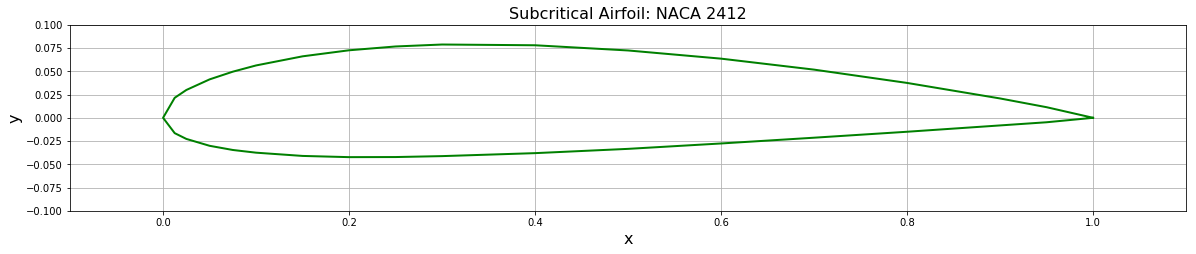

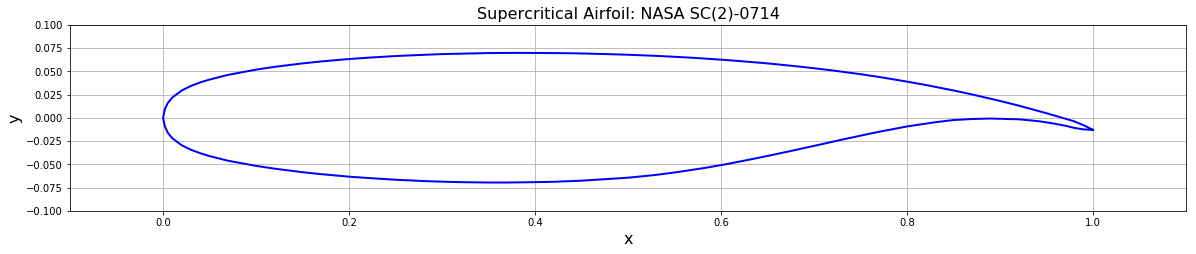

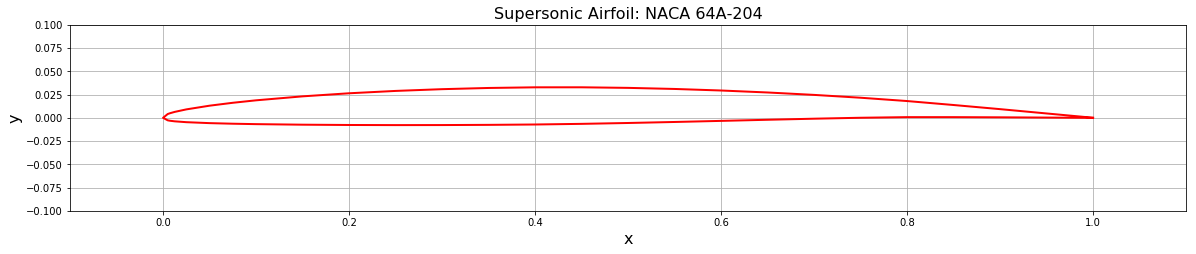

In [4]:
width = 20

plt.figure(figsize=(width, width))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(subx, suby, color='g', linestyle='-', linewidth=2)
plt.axis('scaled', adjustable='box')
plt.title('Subcritical Airfoil: NACA 2412', fontsize=16)
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1);

plt.figure(figsize=(width, width))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(scx, scy, color='b', linestyle='-', linewidth=2)
plt.axis('scaled', adjustable='box')
plt.title('Supercritical Airfoil: NASA SC(2)-0714', fontsize=16)
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1);

plt.figure(figsize=(width, width))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(supx, supy, color='r', linestyle='-', linewidth=2)
plt.axis('scaled', adjustable='box')
plt.title('Supersonic Airfoil: NACA 64A-204', fontsize=16)
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1);

## 2. Panel Method from Python

### Discretizing the Airfoils into Panels

The flow for each airfoil will be solved using the panel method. This means the geometry will be discretized into panels using the data points given from the text files. Panels are defined by two endpoints and a center point, which will be the location for the total source and vortex contribution for its respective panel. 

In [5]:
class Panel:
    def __init__(self,xa,ya,xb,yb):
        '''
        Initialize Panel
        
        Set endpoint, calculate center points, set angle wrt x axis of panel 
        '''
        
        self.xa,self.ya = xa,ya #panel start
        self.xb,self.yb = xb,yb #panel end    
        self.xc, self.yc = (xb+xa)/2, (yb+ya)/2
        self.length = np.sqrt((xb-xa)**2+(yb-ya)**2)
        
        if xb - xa <= 0.0:
            self.beta = np.arccos((yb-ya)/self.length)
        elif xb - xa > 0.0:
            self.beta = np.pi + np.arccos(-(yb-ya)/self.length)
        
        #location of panel
        if self.beta <= np.pi:
            self.loc = 'upper'  # upper surface
        else:
            self.loc = 'lower'  # lower surface
        
        #initialization
        self.sigma = 0.0  # source strength
        self.vt = 0.0  # tangential velocity
        self.cp = 0.0  # pressure coefficient

In [6]:

def define_panels(x,y):
    '''
    Discretizes geometry into panels
    '''
    N = x.size-1 #number of panel is number of points minus 1
    
    panels = np.empty(N, dtype=object)
    
    for i in range(N):
        panels[i] = Panel(x[i],y[i],x[i+1],y[i+1])
    
    return panels
'''
def define_panels(x, y, N=40):
    
    R = (x.max() - x.min()) / 2.0  # circle radius
    x_center = (x.max() + x.min()) / 2.0  # x-coordinate of circle center
    
    theta = np.linspace(0.0, 2.0 * np.pi, N + 1)  # array of angles
    x_circle = x_center + R * np.cos(theta)  # x-coordinates of circle
    
    x_ends = np.copy(x_circle)  # x-coordinate of panels end-points
    y_ends = np.empty_like(x_ends)  # y-coordinate of panels end-points
    
    # extend coordinates to consider closed surface
    x, y = np.append(x, x[0]), np.append(y, y[0])
    
    # compute y-coordinate of end-points by projection
    I = 0
    for i in range(N):
        while I < len(x) - 1:
            if (x[I] <= x_ends[i] <= x[I + 1]) or (x[I + 1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I + 1] - y[I]) / (x[I + 1] - x[I])
        b = y[I + 1] - a * x[I + 1]
        y_ends[i] = a * x_ends[i] + b
    y_ends[N] = y_ends[0]
    
    # create panels
    panels = np.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1])
    
    return panels
'''

'\ndef define_panels(x, y, N=40):\n    \n    R = (x.max() - x.min()) / 2.0  # circle radius\n    x_center = (x.max() + x.min()) / 2.0  # x-coordinate of circle center\n    \n    theta = np.linspace(0.0, 2.0 * np.pi, N + 1)  # array of angles\n    x_circle = x_center + R * np.cos(theta)  # x-coordinates of circle\n    \n    x_ends = np.copy(x_circle)  # x-coordinate of panels end-points\n    y_ends = np.empty_like(x_ends)  # y-coordinate of panels end-points\n    \n    # extend coordinates to consider closed surface\n    x, y = np.append(x, x[0]), np.append(y, y[0])\n    \n    # compute y-coordinate of end-points by projection\n    I = 0\n    for i in range(N):\n        while I < len(x) - 1:\n            if (x[I] <= x_ends[i] <= x[I + 1]) or (x[I + 1] <= x_ends[i] <= x[I]):\n                break\n            else:\n                I += 1\n        a = (y[I + 1] - y[I]) / (x[I + 1] - x[I])\n        b = y[I + 1] - a * x[I + 1]\n        y_ends[i] = a * x_ends[i] + b\n    y_ends[N] = y_ends

In [7]:
class Freestream:
    """
    Create freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
       
        self.u_inf = u_inf
        self.alpha = np.radians(alpha)  # degrees to radians

In [8]:
u_inf = 1.0
alpha = 0.0
freestream = Freestream(u_inf,alpha)

panelssub = define_panels(subx,suby)
panelssc = define_panels(scx,scy)
panelssup = define_panels(supx,supy)

### Building the Linear System 

The velocity potential is created using super position with the source strength contribution and vortex strength at the panel centers. Just as in previous assignments, the linear system for each respective airfoil is constructed by applying the flow tangency boundary condition to every panel center. Each panel has its own source strength contribution while the vortex contribution for each panel is constant. Discretized, this expression becomes, 

$$
\begin{align*}
0 &= V_\infty \cos \left(\alpha-\beta_i\right) + \frac{\sigma_i}{2} \\
&+ \sum_{j=1,j\neq i}^N \frac{\sigma_j}{2\pi} \int_j \frac{\left(x_{c_i}-x_j\right)\frac{\partial x_{c_i}}{\partial n_i} + \left(y_{c_i}-y_j\right)\frac{\partial y_{c_i}}{\partial n_i}}{\left(x_{c_i}-x_j\right)^2 + \left(y_{c_i}-y_j\right)^2}{\rm d}s_j\\
&- \sum_{j=1,j\neq i}^N \frac{\gamma}{2\pi} \int_j \frac{\left(x_{c_i}-x_j\right)\frac{\partial y_{c_i}}{\partial n_i} - \left(y_{c_i}-y_j\right)\frac{\partial x_{c_i}}{\partial n_i}}{\left(x_{c_i}-x_j\right)^2 + \left(y_{c_i}-y_j\right)^2}{\rm d}s_j
\end{align*}
$$

where
$$
\frac{\partial x_{c_i}}{\partial t_i} = -\sin \beta_i,\hspace{0.5cm} \frac{\partial y_{c_i}}{\partial t_i} = \cos \beta_i
$$
and
$$
x_j = x - \sin(\beta_j)s_j,\hspace{0.5cm} y_j = y + \cos(\beta_j)s_j
$$

In [9]:
def integral(x, y, panel, dxdk, dydk):
    def integrand(s):
        return (((x-(panel.xa-np.sin(panel.beta)*s))*dxdk + (y-(panel.ya+np.cos(panel.beta)*s))*dydk)/
                ((x-(panel.xa-np.sin(panel.beta)*s))**2 + (y-(panel.ya+np.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

#----------------------------------------------------------------------------------------------------------------#

def source_contrib(panels):
    '''
    Build source contribution matrix for normal velocity
    '''
    
    A = np.empty((panels.size,panels.size), dtype= float)
    
    np.fill_diagonal(A,0.5)
    for i,panel_i in enumerate(panels):
        for j,panel_j in enumerate(panels):
            if i != j:
                A[i,j] = 0.5/np.pi*integral(panel_i.xc,panel_i.yc,panel_j,np.cos(panel_i.beta),np.sin(panel_i.beta))
    
    return A

#------------------------------------------------------------------------------------------------------------------#

def vortex_contrib(panels):
    '''
    Build vortex contribution matrix for normal velocity
    '''
    
    A = np.empty((panels.size,panels.size), dtype= float)
    
    np.fill_diagonal(A,0.0)
    for i,panel_i in enumerate(panels):
        for j,panel_j in enumerate(panels):
            if i != j:
                A[i,j] = -0.5/np.pi*integral(panel_i.xc,panel_i.yc,panel_j,np.sin(panel_i.beta),-np.cos(panel_i.beta))
    
    return A

In [10]:
A_sourcesub = source_contrib(panelssub)
B_vortexsub = vortex_contrib(panelssub)

A_sourcesc = source_contrib(panelssc)
B_vortexsc = vortex_contrib(panelssc)

A_sourcesup = source_contrib(panelssup)
B_vortexsup = vortex_contrib(panelssup)

The system is represented by a $(N+1)$ x $(N+1)$ size matrix. The first $N$ rows and columns are represented by the source contribution matrix and the last column is the vortex contribution array after summing the vortex rows.  

\begin{equation}
\begin{split}
&\left[\begin{matrix} A^n_{i1} && A^n_{i2} && ... && A^n_{iN} && \left(\sum_{j=1}^N B^n_{ij}\right) \end{matrix}\right]\left[\begin{matrix} \sigma_1 \\ \sigma_2 \\ \vdots \\ \sigma_N \\ \gamma \end{matrix}\right]
=-b^n_i \\
&,\ \ for\  
i=1\sim N
\end{split}
\end{equation}

Also, it is necessary to enforce the Kutta condition in order to place the stagnation point at the trailing edge. The last row of the singularity matrix is represented by the following array,

$$
\begin{bmatrix}
(A^t_{11}+A^t_{N1}) \\
\vdots \\ 
(A^t_{1N}+A^t_{NN}) \\
\left( \sum_{j=1}^N (B^t_{1j}+B^t_{Nj}) \right)
\end{bmatrix}^T
$$

Also, it is important to remember,

* the matrix respresenting the vortex contribution on the normal velocity, $B^n$, is equivalent to the matrix representing the sources contribution on the tangential velocity, $A^t$, i.e.

$$B^n_{ij}=A^t_{ij} \quad \forall (i, j) \in \{1, \cdots, N\}^2$$

* the matrix respresenting the vortex contribution on the tangential velocity, $B^t$, is equivalent to the negative of the matrix representing the sources contribution on the normal velocity, $-A^n$, i.e.

$$B^t_{ij}=-A^n_{ij} \quad \forall (i, j) \in \{1, \cdots, N\}^2$$

Therefore, we do not need to define functions for the tangential A and B matrix since they are proportional to normal B and A matrix, respectively.

In [11]:
def build_singularity_matrix(A_source, B_vortex):
    """
    Builds the LHS matrix of the system arising from source and vortex contributions.
    """
    
    A = np.empty((A_source.shape[0] + 1, A_source.shape[1] + 1), dtype=float)
    
    A[:-1, :-1] = A_source
    
    # vortex contribution array
    A[:-1, -1] = np.sum(B_vortex, axis=1)
    
    #Enforce Kutta condition
    b = np.empty(A_source.shape[0] + 1, dtype=float)
    
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]  #Note: B^n  = A^t
    b[-1] = - np.sum(A_source[0, :] + A_source[-1, :]) #Note: -A^n = B^t
    
    A[-1, :] = b
    
    return A

On the right hand side, all values that do not depend on source and vortex strengths is stored.

In [12]:
def build_freestream_rhs(panels, freestream):
    """
    Builds the RHS of the system arising from the freestream contribution.
    
    """
    b = np.empty(panels.size + 1, dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-1] = -freestream.u_inf * (np.sin(freestream.alpha - panels[0].beta) +
                                 np.sin(freestream.alpha - panels[-1].beta) )
    return b

__We will now solve this linear system at 0$^o$ angle of attack for each airfoil to compute source and vortex strengths at each panel. We will also do an accuracy check to ensure that the sum off all the source strengths is equal to approximately 0__

In [13]:
#Subsonic
Asub = build_singularity_matrix(A_sourcesub,B_vortexsub)
bsub = build_freestream_rhs(panelssub,freestream)
strengthsub = np.linalg.solve(Asub,bsub)

for i , panel in enumerate(panelssub):
    panel.sigma = strengthsub[i]
gammasub = strengthsub[-1]

#Supercritical
Asc = build_singularity_matrix(A_sourcesc,B_vortexsc)
bsc = build_freestream_rhs(panelssc,freestream)
strengthsc = np.linalg.solve(Asc,bsc)

for i , panel in enumerate(panelssc):
    panel.sigma = strengthsc[i]
gammasc = strengthsc[-1]

#Supersonic
Asup = build_singularity_matrix(A_sourcesup,B_vortexsup)
bsup = build_freestream_rhs(panelssup,freestream)
strengthsup = np.linalg.solve(Asup,bsup)

for i , panel in enumerate(panelssup):
    panel.sigma = strengthsup[i]
gammasup = strengthsup[-1]

print(sum([panel.sigma*panel.length for panel in panelssub]))
print(sum([panel.sigma*panel.length for panel in panelssc]))
print(sum([panel.sigma*panel.length for panel in panelssup]))

0.00438384115115
0.00279631286532
0.000673880302188


So far so good it would seem

### Finding Pressure Coefficient 

To find pressure coefficients, it is first necessary to compute the tangential velocity at each panel center 

In [14]:
def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    """
    A = np.empty((panels.size,panels.size+1), dtype=float)
    
    A[:, :-1] = B_vortex
    
    A[:, -1] = -np.sum(A_source, axis=1)

    b = freestream.u_inf*np.sin([freestream.alpha - panel.beta for panel in panels])
    
    strengths = np.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = np.dot(A, strengths)+b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

Pressure coefficent at each panel center is calculated using the equation,

$$C_{p_i} = 1 - \left(\frac{V_{t_i}}{U_\infty}\right)^2$$

In [15]:
def compute_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / freestream.u_inf)**2

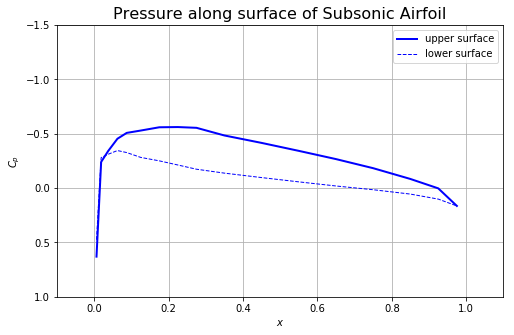

In [16]:
compute_tangential_velocity(panelssub, freestream, gammasub, A_sourcesub, B_vortexsub)
compute_pressure_coefficient(panelssub, freestream)

plt.figure(figsize=(8, 5))
plt.grid()
plt.xlabel('$x$')
plt.ylabel('$C_p$')
plt.plot([panel.xc for panel in panelssub if panel.loc == 'upper'],[panel.cp for panel in panelssub if panel.loc == 'upper'], label='upper surface',
            color='b', linestyle='-', linewidth=2)
plt.plot([panel.xc for panel in panelssub if panel.loc == 'lower'], [panel.cp for panel in panelssub if panel.loc == 'lower'], label= 'lower surface',
            color='b', linestyle='--', linewidth=1)
plt.legend(loc='best')
plt.xlim(-0.1, 1.1)
plt.ylim(1.0, -1.5)
plt.title('Pressure along surface of Subsonic Airfoil', fontsize=16);

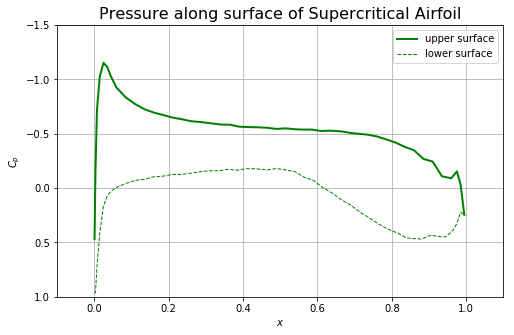

In [17]:
compute_tangential_velocity(panelssc, freestream, gammasc, A_sourcesc, B_vortexsc)
compute_pressure_coefficient(panelssc, freestream)

plt.figure(figsize=(8, 5))
plt.grid()
plt.xlabel('$x$')
plt.ylabel('$C_p$')
plt.plot([panel.xc for panel in panelssc if panel.loc == 'upper'],[panel.cp for panel in panelssc if panel.loc == 'upper'], label='upper surface',
            color='g', linestyle='-', linewidth=2)
plt.plot([panel.xc for panel in panelssc if panel.loc == 'lower'], [panel.cp for panel in panelssc if panel.loc == 'lower'], label= 'lower surface',
            color='g', linestyle='--', linewidth=1)
plt.legend(loc='best')
plt.xlim(-0.1, 1.1)
plt.ylim(1.0, -1.5)
plt.title('Pressure along surface of Supercritical Airfoil', fontsize=16);

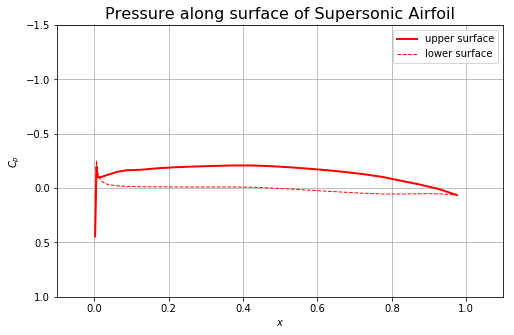

In [18]:
compute_tangential_velocity(panelssup, freestream, gammasup, A_sourcesup, B_vortexsup)
compute_pressure_coefficient(panelssup, freestream)

plt.figure(figsize=(8, 5))
plt.grid()
plt.xlabel('$x$')
plt.ylabel('$C_p$')
plt.plot([panel.xc for panel in panelssup if panel.loc == 'upper'],[panel.cp for panel in panelssup if panel.loc == 'upper'], label='upper surface',
            color='r', linestyle='-', linewidth=2)
plt.plot([panel.xc for panel in panelssup if panel.loc == 'lower'], [panel.cp for panel in panelssup if panel.loc == 'lower'], label= 'lower surface',
            color='r', linestyle='--', linewidth=1)
plt.legend(loc='best')
plt.xlim(-0.1, 1.1)
plt.ylim(1.0, -1.5)
plt.title('Pressure along surface of Supersonic Airfoil', fontsize=16);

### Finding Lift Coefficient

The lift coefficient is defined as lift per unit span over dynamic pressure,

$$ c_l = \frac{L}{qc} = \frac{L}{\frac{1}{2} \rho U_\infty^2c}$$

lift is given by the Kutta-Joukowski theorem , $L =\rho \Gamma U_\infty$ where $\Gamma$ is total circulation and is given by,

$$ \Gamma = \sum_{i=1}^N \gamma l_i$$

### Solving for Lift Coefficient With Respect to AoA: Python Results

The following function carries out the process above to solve for the lift coefficient at given angles of attack for each airfoil. Freestream conditions remain constant. The result is plotted to observe trends.

In [36]:
def get_lift_coefficient(panels,freestream):
    
    A_source = source_contrib(panels)
    B_vortex = vortex_contrib(panels)
    
    A = build_singularity_matrix(A_source,B_vortex)
    b = build_freestream_rhs(panels,freestream)
    strengths = np.linalg.solve(A,b)
    
    for i , panel in enumerate(panels):
        panel.sigma = strengths[i]
    gamma = strengths[-1]
    
    c = abs(max(panel.xa for panel in panels) - min(panel.xa for panel in panels))
    cl = (gamma * sum(panel.length for panel in panels) / (0.5 * freestream.u_inf * c))
    
    return cl

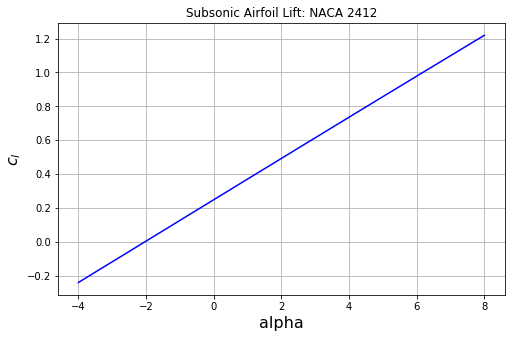

In [41]:
#create array for AoA for data points
u_inf
alpha_low = -4.0
alpha_high = 8.0
alphas = np.linspace(alpha_low,alpha_high, int(alpha_high-alpha_low+1))
cl_sub = np.empty(np.size(alphas), dtype=float)

for i in range(np.size(alphas-1)):
    freestream = Freestream(u_inf,alphas[i])
    cl_sub[i] = get_lift_coefficient(panelssub,freestream)
    
plt.figure(figsize=(8,5))
plt.grid()
plt.plot(alphas,cl_sub, color = 'b')
plt.xlabel('alpha', fontsize = 16)
plt.ylabel('$c_l$', fontsize=16)
plt.title('Subsonic Airfoil Lift: NACA 2412')

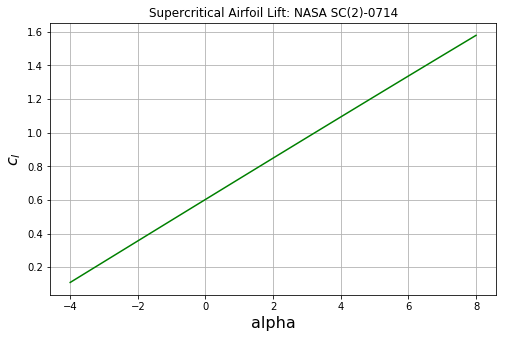

In [42]:
cl_sc = np.empty(np.size(alphas), dtype=float)
for i in range(np.size(alphas-1)):
    freestream = Freestream(u_inf,alphas[i])
    cl_sc[i] = get_lift_coefficient(panelssc,freestream)

plt.figure(figsize=(8,5))
plt.grid()
plt.plot(alphas,cl_sc, color = 'g')
plt.xlabel('alpha', fontsize = 16)
plt.ylabel('$c_l$', fontsize=16)
plt.title('Supercritical Airfoil Lift: NASA SC(2)-0714')

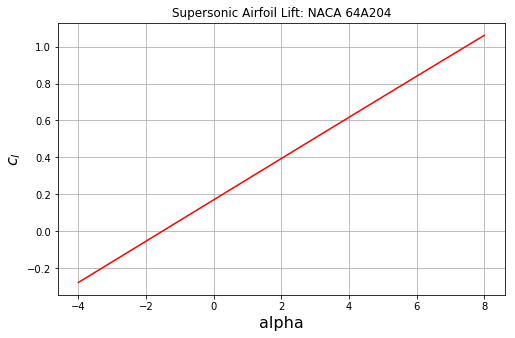

In [43]:
cl_sup = np.empty(np.size(alphas), dtype=float)  
for i in range(np.size(alphas-1)):
    freestream = Freestream(u_inf,alphas[i])
    cl_sup[i] = get_lift_coefficient(panelssup,freestream)
    
plt.figure(figsize=(8,5))
plt.grid()
plt.plot(alphas,cl_sup, color = 'r')
plt.xlabel('alpha', fontsize = 16)
plt.ylabel('$c_l$', fontsize=16)
plt.title('Supersonic Airfoil Lift: NACA 64A204')

Before we analyze this data, we will first compare these values to values gathered from simulations in XFLR5. This will help confirm whether or not the values are sensible.

## 3. Results from Panel Method in XFLR5

### Set up

 The same three airfoils were loaded onto an XFLR5 XFoil direct analysis. Each foil was defined with 100 panels, with higher panel density towards the leading and trailing edges. A type 1 polars batch analysis was run over a range of reynold's numbers varying from 2e4 to 1e6. Mach number was set to a constant 0.0 and the transition criteria from laminar to turbulent flow was set to 9.0. 

For each reynold's number, a simulation was run for angle of attack values from -6.0$^o$ to 15.0$^o$ with a step size of 0.5. Convergence critia was set to be less than 100 iterations. The flow was set to be viscous, with boundary layers reinitialized after nonconverged points. 

### Pressure Results

The results for the OpPoints which displays surface pressure coefficient as a function of x position along the airfoil can be seen directly below. First thing to notice is that the results match well with the general shape the values found from the Python simulation created. This confirms that the pressure coefficients solved previously were accurate with some discrepencies likely due to set simulation conditions. Most notably, the Python code simulates potential flow, which is inviscid and therefore utilizes a Reynold's number of infinity. The XFoil analysis displays OpPoints for a Reynold's number of only 1e5. XFLR5 was designed to be a analysis tool for low Reynold's numbers. Higher Reynold's numbers would have generated turbulence and many unconverged points.    

<img src="resources/xfoilcp.PNG", width=800, height=400>

The largest discrepency is found in the OpPoints for the NASA SC2-0714. At first glance, it would seem that the Python results for this airfoil seems more unrealistic. The surface pressures closer to the trailing edge become sporadic a suddenly increase very suddenly. The XFoil results do not appear to be too sensical towards the trailing edge either, seeing as higher pressure alternates between the lower surface and the upper surface more than once. This strange behavior could likely be due to the necessary modifications made to data file which created a sudden sharp point (see statements previously in Introduction). 

The results for the other airfoils are mostly the same general shape as well as magnitude. Since the NACA 2412 and NACA 64A-204 are very different airfoils, these two should be mainly focused on. At first glace, it should be notcied that the pressure differential from the upper to the lower surfaces is much greater for the NACA 2412 than for the NACA 64A-204. Since the NACA 64A-204 is nearly a thin plate, there the flow has little ability to change pressure from this geometry. This behavior holds true for many supersonic airfoil designs. Since it is the pressure differential that causes lifting force, the results are confirming known subsonic airfoil performance that at low speeds. Compared to supersonic airfoils, subsonic airfoils are able to generate more lift at subsonic speeds due to their geometry. Results at varying speeds are observed in the next section. 

### Lift Results

The polars used are coefficient of lift with respect to angle of attack and coefficient of lift with respect to coefficient of drag. We can ignore some of the plots for certain reynold's numbers. This indicates a flow separation transition has occured or that discontinuities have not been worked out. Some discontinued have been refined by running the same simulation at the respective reynold's number for smaller angle of attack step size.  

<img src="resources/NACA2412M0.PNG", width=1000, height=400>

The right polar above for the NACA 2412 shows that lift is generally high even at high angles of attack. At lower speeds a maximum lift coefficient can be observed. This indicates that stall has occurred which can be delayed at higher speeds. Once again we can compare these values to the values found in the Python simulations. Lift coefficients at respective angles of attack have similar magnitudes, which is a sign that both results are fairly accurate. This can be seen as the case for all three airfoils used in this investigation.

The left polar highlights an important consideration for airfoil design. The airfoil must produce low drag while generating lifts in the highly steep portion of the plot. The bottom limit of this portion indicates that the transition point is moving rapidly along the lower surface, while the upper limit indicates that the transition point is moving along the upper surface. Depending on where these limits occur, lower and upper surface designs should be considered.

  <img src="resources/NASASCM0.PNG", width=1000, height=400>
  
The polars above for the NASA SC(2)-0714 have insight to offer about the performance of supercritical airfoils. We can see that the airfoil is more likely to stall and transition at slower speeds. The values for the data across various reynolds numbers varies greatly, which may be an indicator that its optimal operating condition range has yet to be created for this simulation.

<img src="resources/NACA64AM0.PNG", width=1000, height=400>

The performance drops even more so for the NACA 64A-204 than for the NASA SC(2)-204. For most reynolds numbers explored in this analysis, the aircraft stalls at only 5$^o$ angle of attack! Much lower coefficients of lift are observed which will generate even lower total lift if we consider the small wetted area featured on most supersonic aircrafts. 

An increase in drag can also be noticed at the reynold's numbers tested. The optimal lift portion of the polars is not nearly as steep as the polars for the NACA 2412. This behavior indicates that high drag occurs even when the lift is low. This observation is justified if we consider that the geometry of the NACA 64A-204 and similar airfoils is largely flat.  

Even if higher speeds and supersonic speeds are used in simulation, high lift as seen with the NACA 2412 and NASASC(2)-0714 would not be expected to occur. This must be why many supersonic fighters are designed with lift assisting mechanisms. The wing geometry itself is not enough to generate sufficient lift. The main purpose of the thin and sharp design of supersonic airfoils is to reduce drag from flow separation and the formation of bow shocks at __supersonic__ speeds.   

## 4. Conclusion

There has yet to be an airfoil developed that performs efficiently across all speeds. Therefore, from incoming airflow alone, a supersonic airfoil should not perform as well as other airfoils in subsonic flow. The results from this investigation confirms this statement. Subsonic airfoils are able to produce a large amount of lift compared to supersonic airfoils in subsonic flow. Also, stall will most likely occur at even small angles of attack for supersonic aircrafts that do not use other lift generating mechanisms. Since supersonic aircrafts must obviously also operate in these slower flight conditions, it is important to determine their aerodynamic characteristics at those speeds. 

## 5. References

* Lindsey, W.F., Daley, Bernard N., and Humphreys, Milton D. "THE FLOW AND FORCE CHARACTERISTICS OF SUPERSONIC AIRFOILS AT HIGH SUBSONIC SPEEDS." National Advisory Committee for Aeronautics
* Hehs, Eric. “Harry Hillaker: Father of the F-16.” Code One. http://www.codeonemagazine.com/article.html?item_id=37
* Ledniser, David. "The Incomplete Guide To Airfoil Usage." http://m-selig.ae.illinois.edu/ads/aircraft.html
* "Subsonic Airfoil Design" http://www.airfoils.com/design.pdf
* https://www.youtube.com/playlist?list=PLtl5ylS6jdP6uOxzSJKPnUsvMbkmalfKg